<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/Brace_angles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [3]:
%ls

 angleModel1/      dataset_pytorch.py        labels                  test_subset.pkl
 annotations/      figures/                  lstm_model2.pth         timeDistModel/
 bracedataset.py   head_floor.PNG            lstm_model.pth          train_subset.pkl
 brace_test.pkl    hip_knee_ankle.PNG       'MODELS ACCURACY.gdoc'   utils/
 brace_test.pth    hip_knee_horizontal.PNG   names                   videos_info.csv
 brace_train.pkl   keras_model/              path/                   wrists_floor.PNG
 brace_train.pth   keypoints_angles.py       __pycache__/
 dataClips         k_model_features/         README.md
 dataset/          k_model_features2/        tensor_dataset.pkl


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [5]:
#only import to get funtion names
import inspect
import keypoints_angles
function_list = [o for o in dir(keypoints_angles) if inspect.isfunction(getattr(keypoints_angles, o))]
print(function_list)

['body_parts', 'calculate_angle', 'calculate_angle_to_horizontal', 'calculate_hand_to_floor_distance', 'calculate_head_position', 'calculate_head_to_floor_distance', 'calculate_leg_angles', 'calculate_mean_angles', 'calculate_mean_distance', 'calculate_mean_hand_distance', 'calculate_mean_leg_angles', 'extract_angles_from_dataset', 'extract_hand_to_floor_distances', 'extract_head_to_floor_distances', 'extract_horizontal_angles_from_df', 'plot_hand_distance_3x2_with_category_names', 'plot_head_to_floor_histograms', 'plot_hip_knee_floor', 'plot_hip_leg_angle']


In [38]:
import pickle
import pandas as pd
import numpy as np
from keypoints_angles import body_parts, calculate_angle, calculate_angle_to_horizontal, calculate_hand_to_floor_distance, calculate_head_position
from keypoints_angles import calculate_head_to_floor_distance, calculate_leg_angles, calculate_mean_angles, calculate_mean_distance
from keypoints_angles import calculate_mean_hand_distance, calculate_mean_leg_angles, extract_angles_from_dataset, extract_hand_to_floor_distances
from keypoints_angles import  extract_head_to_floor_distances, extract_horizontal_angles_from_df, plot_hand_distance_3x2_with_category_names
from keypoints_angles import plot_head_to_floor_histograms, plot_hip_knee_floor, plot_hip_leg_angle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

Import keypoint and labels

In [7]:
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]
#get flatted clips
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

Calculate Keypoint angles

In [8]:
df_body_parts = pd.DataFrame(list(body_parts().keys()), index=body_parts().values(), columns=['bodyParts'])
df_body_parts

,bodyParts
0,Nose
1,Left Eye
2,Right Eye
3,Left Ear
4,Right Ear
5,Left Shoulder
6,Right Shoulder
7,Left Elbow
8,Right Elbow
9,Left Wrist


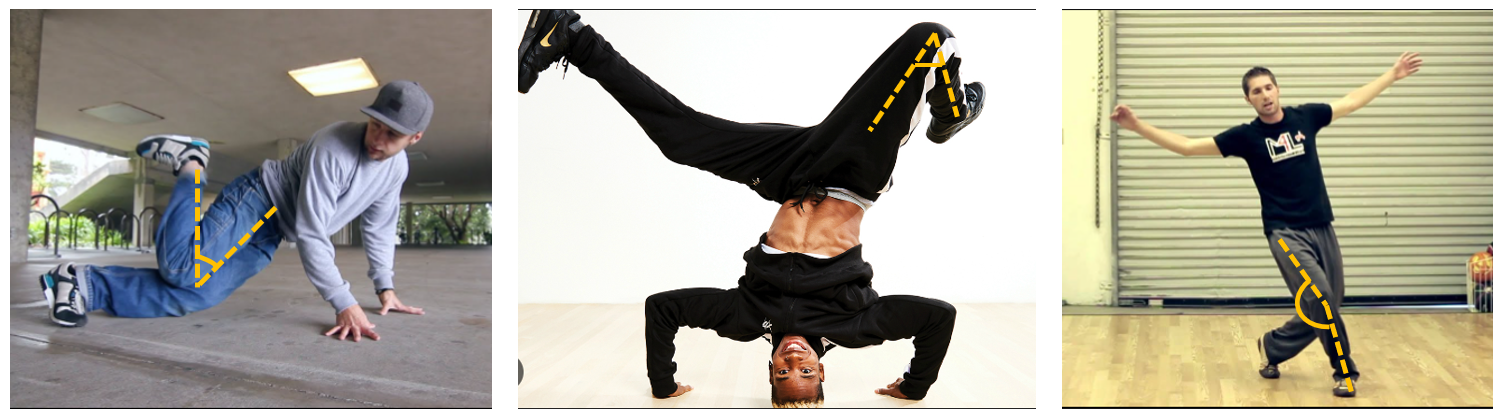

In [9]:
# Keypoint indices for right and left legs
right_keypoints = [12, 14, 16]
left_keypoints = [11, 13, 15]
category_to_int= {'toprock': 0, 'powermove': 1, 'footwork': 2}

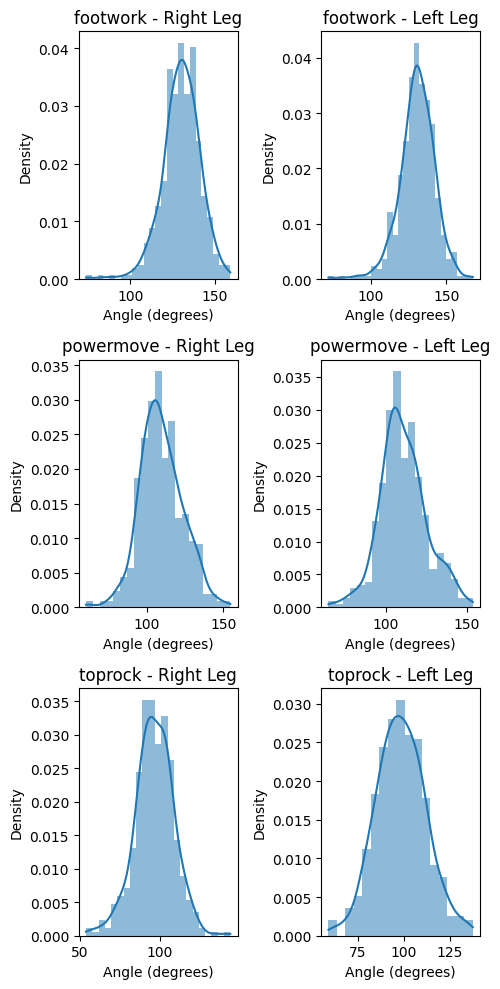

In [10]:
class_angles_hka =extract_angles_from_dataset(flattened_clips, encoded_categories, right_keypoints, left_keypoints)
plot_hip_leg_angle(class_angles_hka, category_to_int)

In [11]:
mean_angles = calculate_mean_angles(class_angles_hka)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 96.61, Mean Left Leg Angle: 98.48
Class powermove - Mean Right Leg Angle: 109.39, Mean Left Leg Angle: 110.93
Class footwork - Mean Right Leg Angle: 130.20, Mean Left Leg Angle: 130.64


Hip Knee horizontal line calculate if the hips are parallel or below the knee like then squatting.

In [12]:
# Keypoint indices for right and left legs (hip, knee)
right_keypoints = [12, 14]  # right hip, right knee
left_keypoints = [11, 13]  # left hip, left knee

# Assuming 'data' is your padded_clips and 'labels' correspond to y_train
hrz_class_angles = extract_horizontal_angles_from_df(flattened_clips, encoded_categories, right_keypoints, left_keypoints)


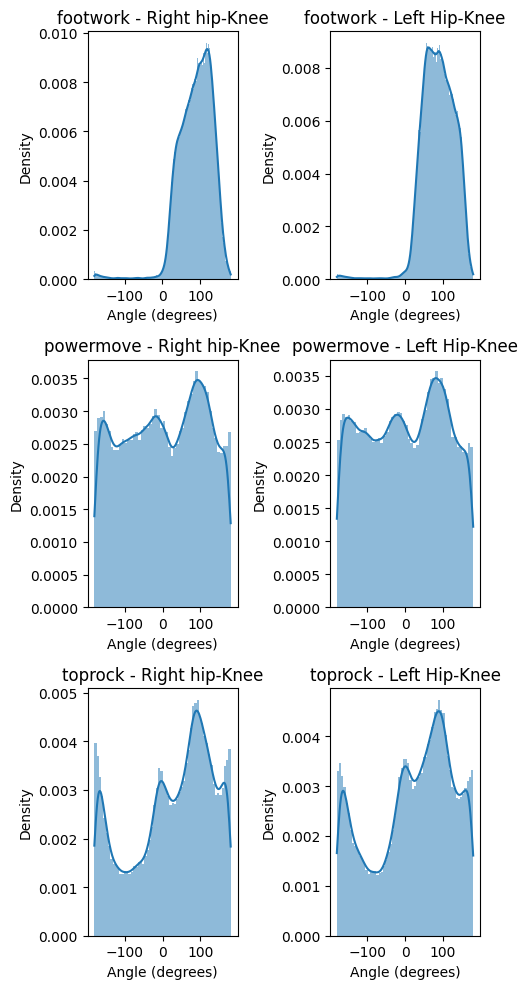

In [13]:
plot_hip_knee_floor(hrz_class_angles, category_to_int)

In [14]:
mean_horz_angles = calculate_mean_angles(hrz_class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_horz_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Hip-Knee-Floor Angle: {mean_horz_angles[label]['right']:.2f}, Mean Hip-Knee-Floor Angle: {mean_horz_angles[label]['left']:.2f}")

Class toprock - Mean Right Hip-Knee-Floor Angle: 24.52, Mean Hip-Knee-Floor Angle: 21.24
Class powermove - Mean Right Hip-Knee-Floor Angle: 2.85, Mean Hip-Knee-Floor Angle: 1.01
Class footwork - Mean Right Hip-Knee-Floor Angle: 88.57, Mean Hip-Knee-Floor Angle: 88.14


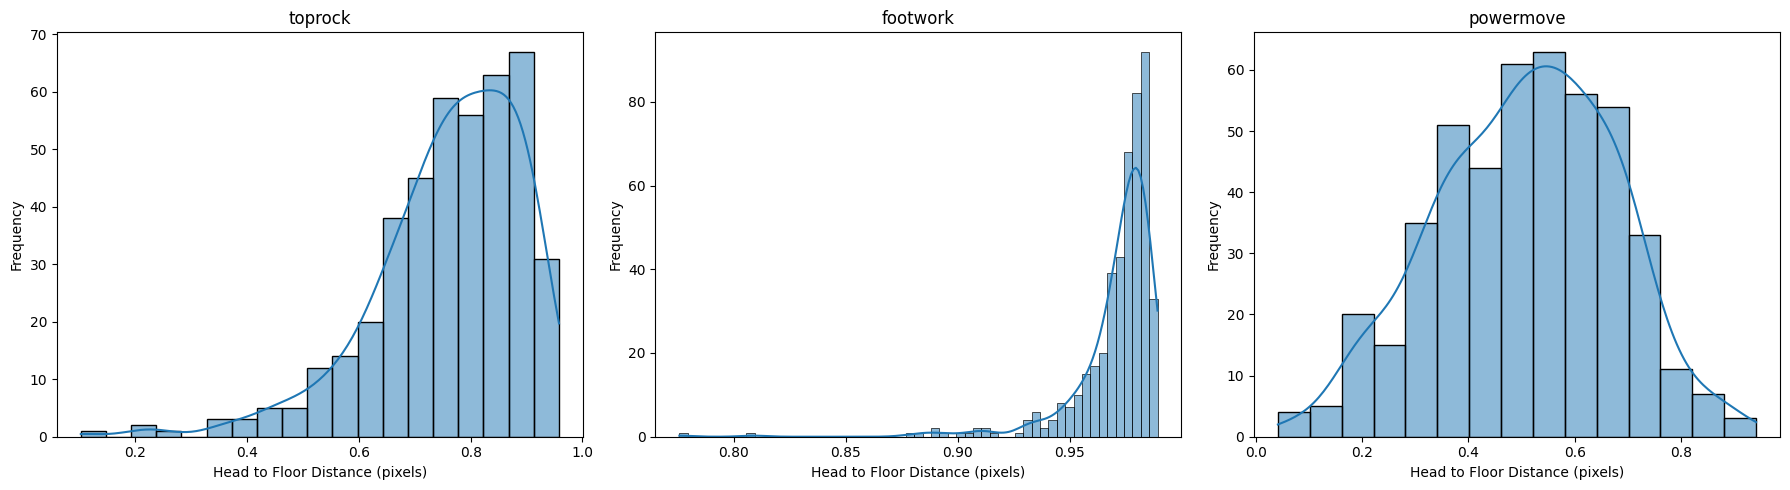

In [15]:
head_to_floor_distances = extract_head_to_floor_distances(flattened_clips, encoded_categories, category_to_int)
plot_head_to_floor_histograms(head_to_floor_distances)

In [16]:
head_dist= calculate_mean_distance(head_to_floor_distances)
head_dist

{'toprock': 0.7607817715982209,
 'footwork': 0.9708167567989453,
 'powermove': 0.5077703016672418}

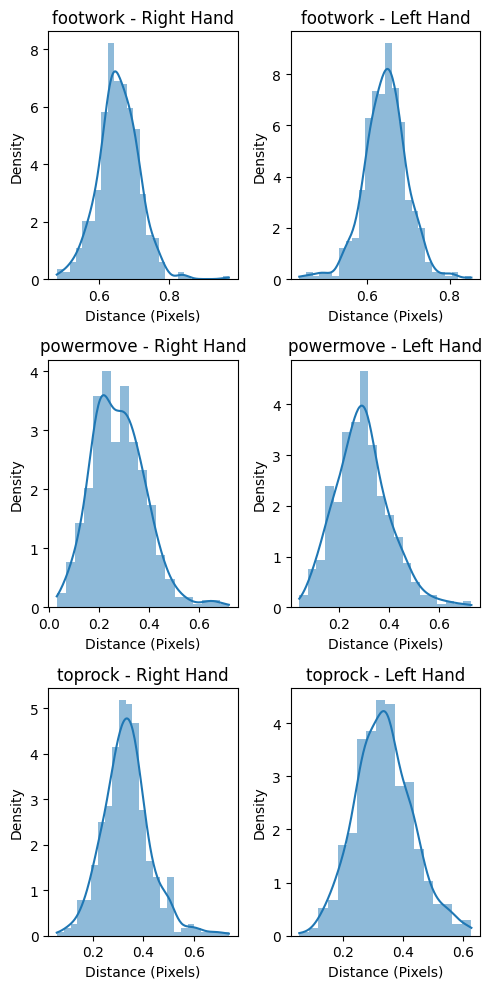

In [17]:
hand_to_floor_distances = extract_hand_to_floor_distances(flattened_clips, encoded_categories)
plot_hand_distance_3x2_with_category_names(hand_to_floor_distances, category_to_int)

In [18]:
mean_hand_angles = calculate_mean_hand_distance(hand_to_floor_distances)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_hand_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean right wrist to floor distance: {mean_hand_angles[label]['right']:.2f}, Mean left wrist to floor distance: {mean_hand_angles[label]['left']:.2f}")

Class toprock - Mean right wrist to floor distance: 0.33, Mean left wrist to floor distance: 0.34
Class powermove - Mean right wrist to floor distance: 0.28, Mean left wrist to floor distance: 0.29
Class footwork - Mean right wrist to floor distance: 0.66, Mean left wrist to floor distance: 0.64


Calculate values for all clips and segments

In [30]:
hip_knee_ankle_angles = []
for clip in flattened_clips:  # Assuming flattened_clips is defined elsewhere
    segment_hip = []
    for segment in clip:
        temp_hip = []
        # Extracting left and right side keypoints for hip, knee, and ankle
        left_hip = np.array([segment[11*2], segment[11*2 + 1]])
        left_knee = np.array([segment[13*2], segment[13*2 + 1]])
        left_ankle = np.array([segment[15*2], segment[15*2 + 1]])

        right_hip = np.array([segment[12*2], segment[12*2 + 1]])
        right_knee = np.array([segment[14*2], segment[14*2 + 1]])
        right_ankle = np.array([segment[16*2], segment[16*2 + 1]])

        # Calculate angles
        left_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_angle = calculate_angle(right_hip, right_knee, right_ankle)

        # Calculate horizontal angles
        left_hip_x, left_hip_y = segment[11*2], segment[11*2 + 1]
        left_knee_x, left_knee_y = segment[13*2], segment[13*2 + 1]
        left_hrz = calculate_angle_to_horizontal((left_hip_x, left_hip_y), (left_knee_x, left_knee_y))

        right_hip_x, right_hip_y = segment[12*2], segment[12*2 + 1]
        right_knee_x, right_knee_y = segment[14*2], segment[14*2 + 1]
        right_hrz = calculate_angle_to_horizontal((right_hip_x, right_hip_y), (right_knee_x, right_knee_y))

        # Calculate head to floor distance
        head_to_floor_distance = calculate_head_to_floor_distance(segment)

        #wrist values
        left_wrist_distance_to_floor = calculate_hand_to_floor_distance(segment, 9)
        right_wrist_distance_to_floor = calculate_hand_to_floor_distance(segment, 10)

        # Append calculated values to temp list
        temp_hip.append(left_angle)
        temp_hip.append(right_angle)
        temp_hip.append(left_hrz)
        temp_hip.append(right_hrz)
        temp_hip.append(head_to_floor_distance)
        temp_hip.append(left_wrist_distance_to_floor)
        temp_hip.append(right_wrist_distance_to_floor)
        segment_hip.append(temp_hip)
    hip_knee_ankle_angles.append(segment_hip)



LSTM model with padding to max lenght

In [31]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='post', dtype='float32')
labels_categorical = to_categorical(encoded_categories)  # One-hot encode labels


In [35]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='post', dtype='float32')
labels_categorical = to_categorical(encoded_categories)  # One-hot encode labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels_categorical, test_size=0.2, random_state=42)

# Model creation
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, 7)),  # Adjust based on your data's feature size
    LSTM(32),
    Dense(3, activation='softmax')  # Output layer for 3 categories
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

Epoch 1/10
34/34 [==============================] - 52s 1s/step - loss: 1.0995 - accuracy: 0.3265 - val_loss: 1.0966 - val_accuracy: 0.3616
Epoch 2/10
34/34 [==============================] - 60s 2s/step - loss: 1.0983 - accuracy: 0.3108 - val_loss: 1.0969 - val_accuracy: 0.3616
Epoch 3/10
34/34 [==============================] - 45s 1s/step - loss: 1.0980 - accuracy: 0.3404 - val_loss: 1.0968 - val_accuracy: 0.3616
Epoch 4/10
34/34 [==============================] - 48s 1s/step - loss: 1.0982 - accuracy: 0.3210 - val_loss: 1.0966 - val_accuracy: 0.3616
Epoch 5/10
34/34 [==============================] - 52s 2s/step - loss: 1.0981 - accuracy: 0.3367 - val_loss: 1.0968 - val_accuracy: 0.3616
Epoch 6/10
34/34 [==============================] - 42s 1s/step - loss: 1.0978 - accuracy: 0.3228 - val_loss: 1.0958 - val_accuracy: 0.3616
Epoch 7/10
34/34 [==============================] - 66s 2s/step - loss: 1.0975 - accuracy: 0.3404 - val_loss: 1.0967 - val_accuracy: 0.3616
Epoch 8/10
34/34 [==

Identify a sorted

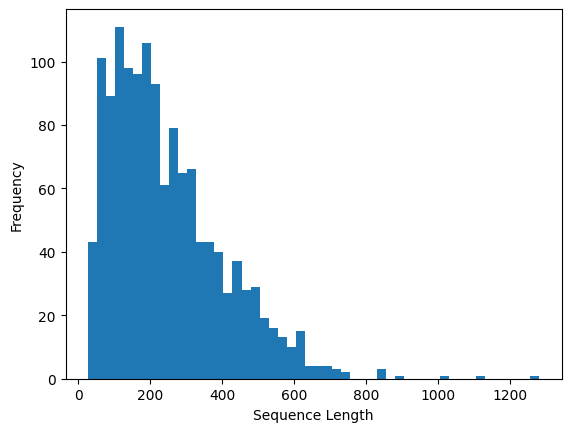

In [36]:
sequence_lengths = [len(seq) for seq in hip_knee_ankle_angles]

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determine a suitable maxlen based on the distribution, for example, the 90th percentile
maxlen = np.percentile(sequence_lengths, 90)

CNN with drop out layers and reduced lenght padding

In [52]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32') #use max lenght to 90 percentile and pretructating.
labels_categorical = to_categorical(encoded_categories)  # One-hot encode labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels_categorical, test_size=0.2, random_state=42)

# Model creation
model = Sequential([
LSTM(128, return_sequences=True, input_shape=(None, 7)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Training
history =model.fit(X_train, y_train, epochs=8, validation_split=0.1)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, None, 128)         69632     
                                                                 
 dropout_10 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 119235 (465.76 KB)
Trainable params: 119235 (465.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
31/3

In [53]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 2s 251ms/step - loss: 0.4508 - accuracy: 0.8155
Test accuracy: 0.8154981732368469


9/9 [==============================] - 3s 249ms/step
              precision    recall  f1-score   support

           0       0.64      0.76      0.70        75
           1       0.82      0.71      0.77        98
           2       0.97      0.96      0.96        98

    accuracy                           0.82       271
   macro avg       0.81      0.81      0.81       271
weighted avg       0.83      0.82      0.82       271



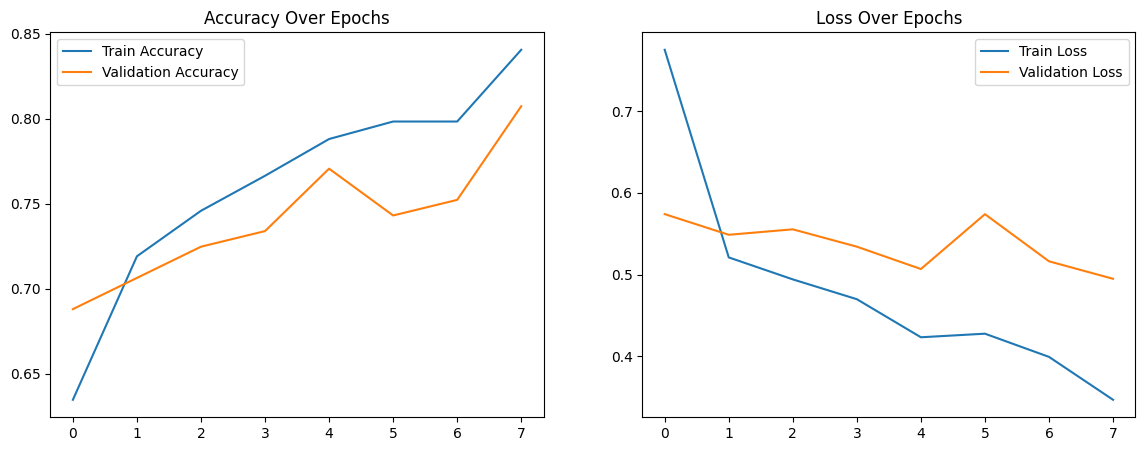

In [54]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix or use seaborn for a nicer plot

# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

In [55]:
category_to_int

{'toprock': 0, 'powermove': 1, 'footwork': 2}